# Data Workflow Lab 2

Proceed with your analysis of the Project 3 data set. You may need to compute new columns as you proceed. Fit one or more linear models to the data, investigate model fits and outliers, use regularization when appropriate.

### Learning objectives
- Perform exploratory analysis
- Generate correlation matrix of the features
- Generate linear regression models
- Evaluate model fit

If appropriate for your models and featuers:
- Use [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html) to pick the best features
- Try different regularization options

In [2]:
#The ultimate model I want to work on is where to potentially open new stores.
#Since I do not have demographic data by county or city or zip, my analysis is a little more limited.

% matplotlib inline

from collections import defaultdict
import datetime

from matplotlib import pyplot as plt
# Make the plots bigger
plt.rcParams['figure.figsize'] = 10, 10
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn import linear_model

In [3]:
# Load the data from the previous lab
# If you changed the name you'll need to edit the next line
#The below file has the sales ONLY for stores that were open from Jan 10, 2015 to the end of Q1 2016.
#This is to avoid bias from new stores, or stores that also closed.
#However, I will also later read in a file to chart by zip and factor the biggest closure rates.
#I will also read in the new stores only for some exploratory analysis.
sales = pd.read_csv("sales_final_combined.csv")

sales_2015_closed = pd.read_csv("sales_2015_closed_stores.csv")
sales_2015_new = pd.read_csv("sales_2015_new_stores.csv")
sales_2016_new = pd.read_csv("sales_Q12016_new_stores.csv")

# Convert dates
sales['First Date'] = pd.to_datetime(sales['First Date'], infer_datetime_format = True)
sales['Last Date'] = pd.to_datetime(sales['Last Date'], infer_datetime_format = True)

sales_2015_closed['First Date'] = pd.to_datetime(sales_2015_closed['First Date'], infer_datetime_format = True)
sales_2015_closed['Last Date'] = pd.to_datetime(sales_2015_closed['Last Date'], infer_datetime_format = True)

sales_2015_new['First Date'] = pd.to_datetime(sales_2015_new['First Date'], infer_datetime_format = True)
sales_2015_new['Last Date'] = pd.to_datetime(sales_2015_new['Last Date'], infer_datetime_format = True)

sales_2016_new['First Date'] = pd.to_datetime(sales_2016_new['First Date'], infer_datetime_format = True)
sales_2016_new['Last Date'] = pd.to_datetime(sales_2016_new['Last Date'], infer_datetime_format = True)

In [4]:
#drop unnamed column
sales.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [5]:
#drop unnamed columns from other dfs
sales_2015_closed.drop(['Unnamed: 0'], axis = 1, inplace = True)
sales_2015_new.drop(['Unnamed: 0'], axis = 1, inplace = True)
sales_2016_new.drop(['Unnamed: 0'], axis = 1, inplace = True)

## Exploratory Analysis
Make some plots, look at correlations, etc.

'Numbers of days open, mean retail price seem to be good continuous variables for regression. The rest look categorical.'

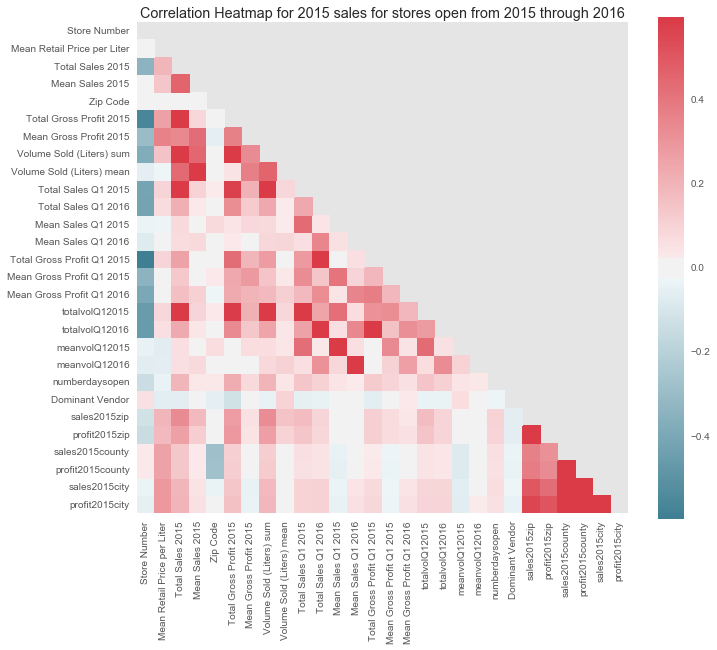

In [9]:
# Compute correlations for 2015 sales
plt.style.use('ggplot')
corr_sales = sales.corr()

#mask for upper triangle
mask = np.zeros_like(corr_sales, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_sales, mask=mask, cmap=cmap, vmax=.3,
            square=True, ax=ax)
plt.title('Correlation Heatmap for 2015 sales for stores open from 2015 through 2016')
'''I am seeing the expected correlations between sales and profits. Where it is weak is zip code, suggesting no correlation between zip code and sales.'''

'''Numbers of days open, mean retail price seem to be good continuous variables for regression. The rest look categorical.'''

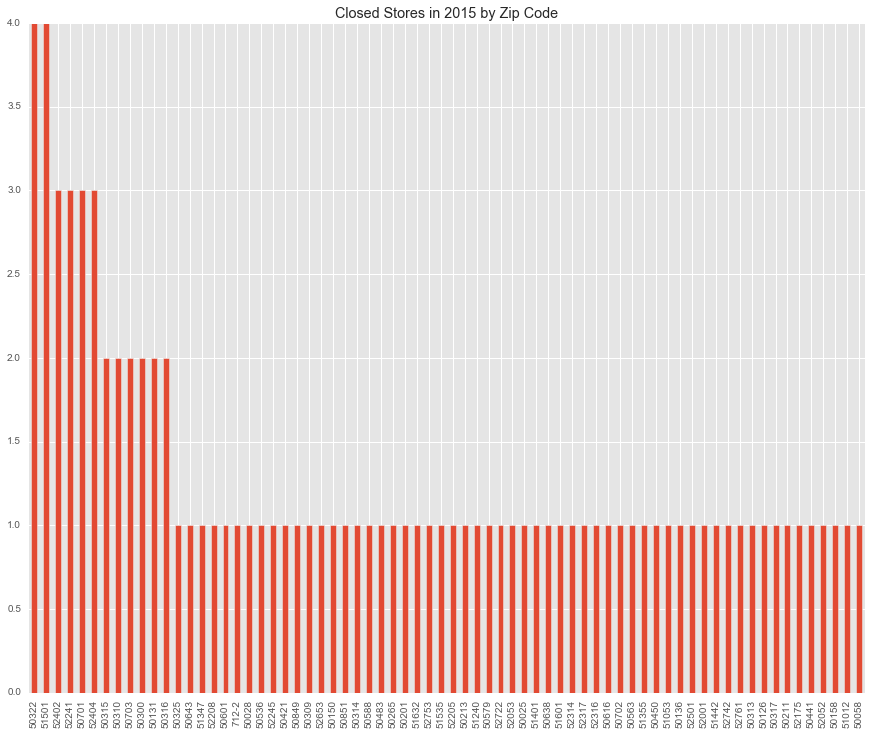

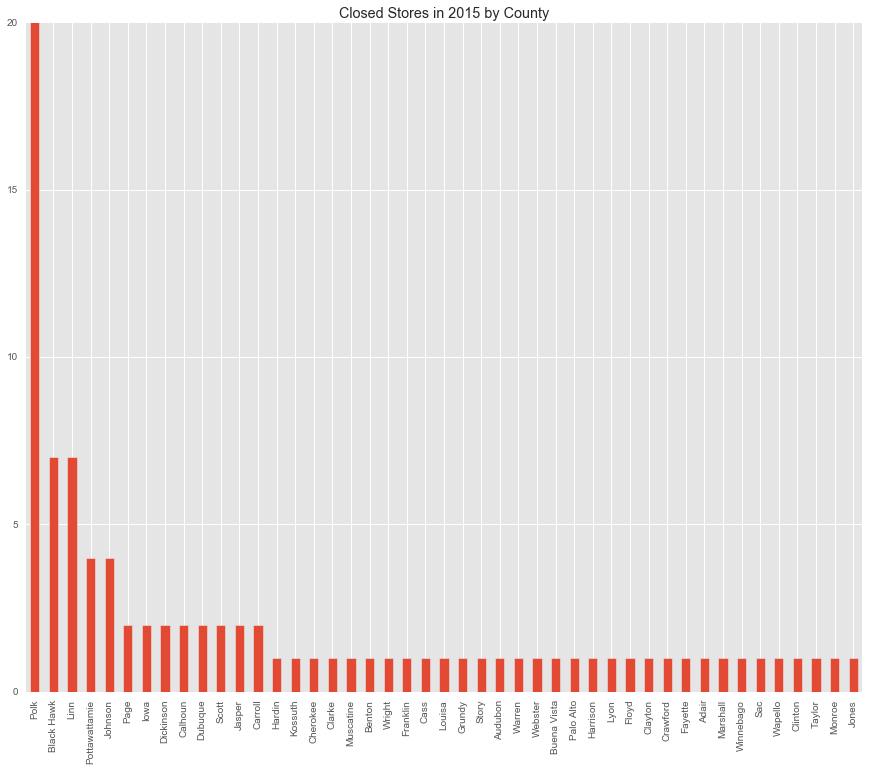

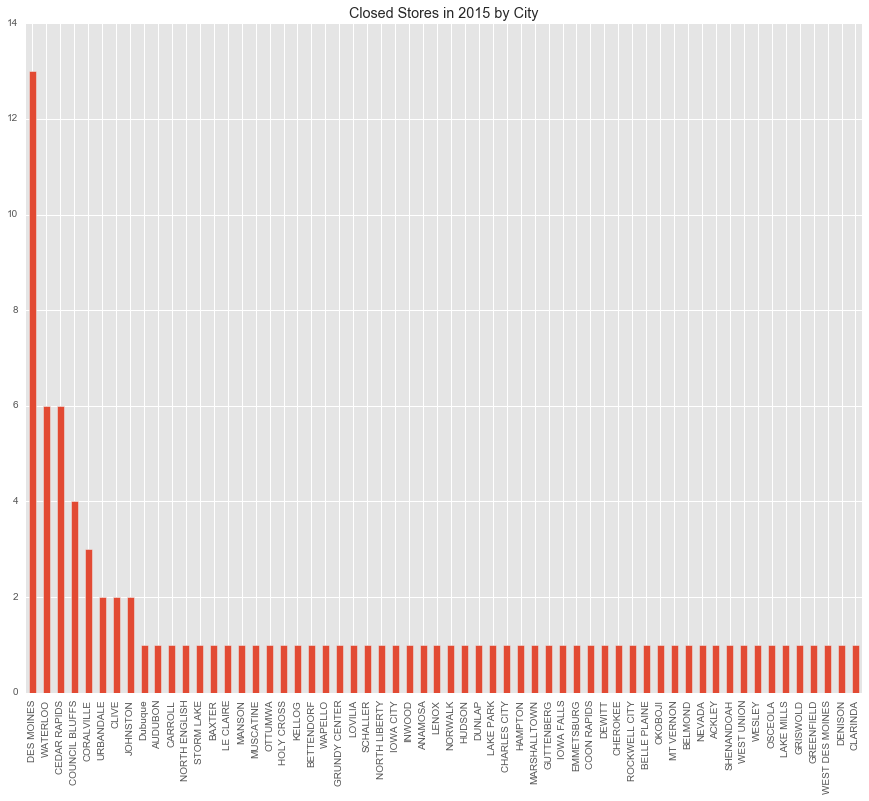

In [8]:
# Perform some exploratory analysis, make a few plots
#I want to chart the count of closed 2015 stores by county, zip, and city.

plt.style.use('ggplot')
plt.figure(1)
sales_2015_closed['Zip Code'].value_counts().plot(kind = 'bar', figsize=(15,12))
plt.title('Closed Stores in 2015 by Zip Code')

'''As can be seen, there are zip codes with a higher number of store closures, but without scale, not as meaningful.'''

plt.figure(2)
sales_2015_closed['County'].value_counts().plot(kind = 'bar', figsize=(15,12))
plt.title('Closed Stores in 2015 by County')

plt.figure(3)
sales_2015_closed['City'].value_counts().plot(kind = 'bar', figsize=(15,12))
plt.title('Closed Stores in 2015 by City')

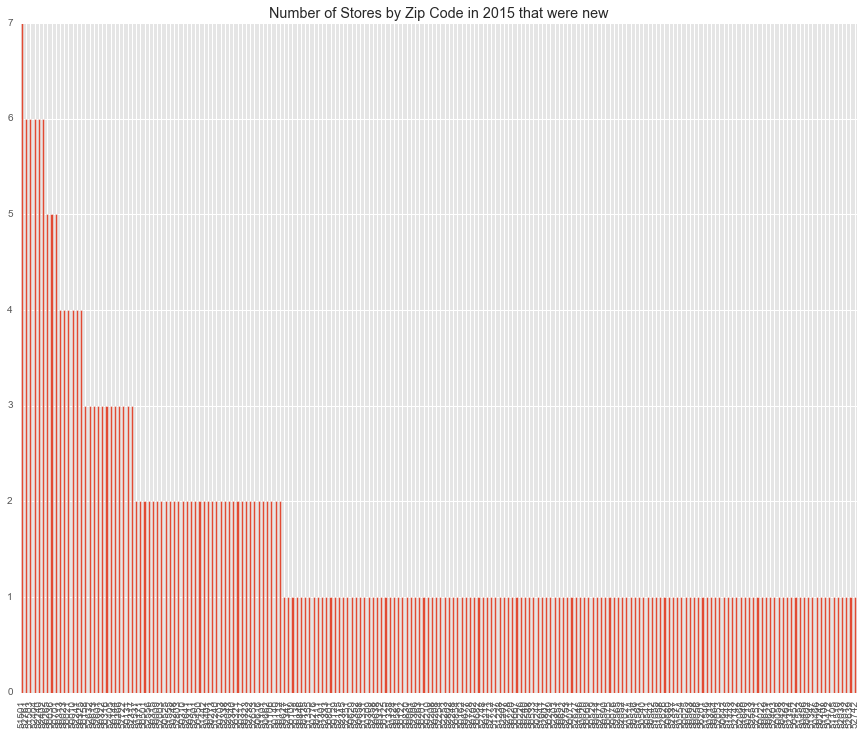

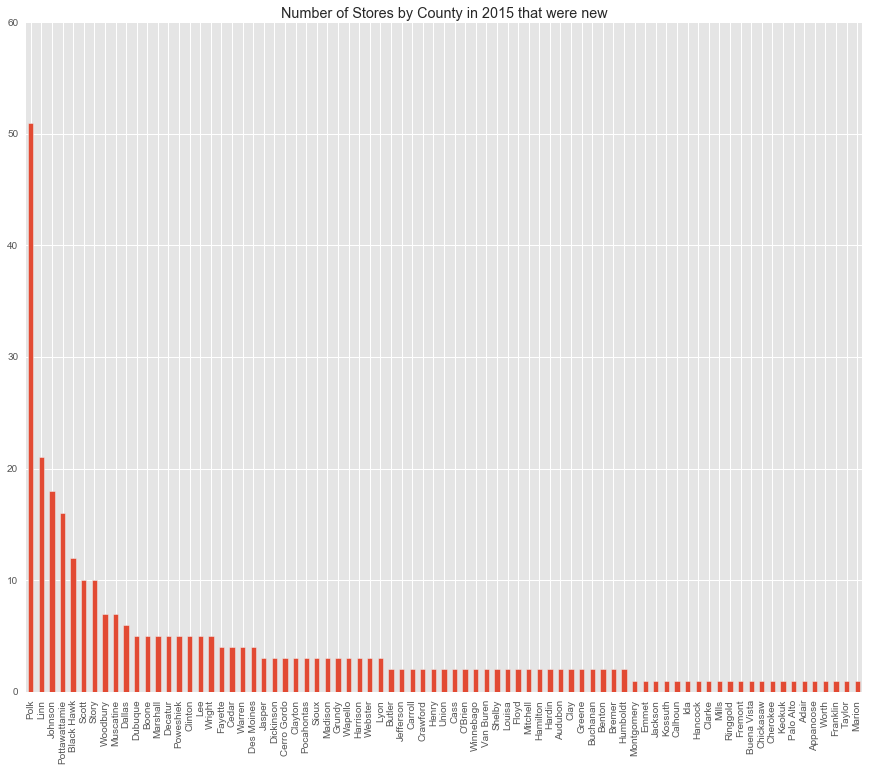

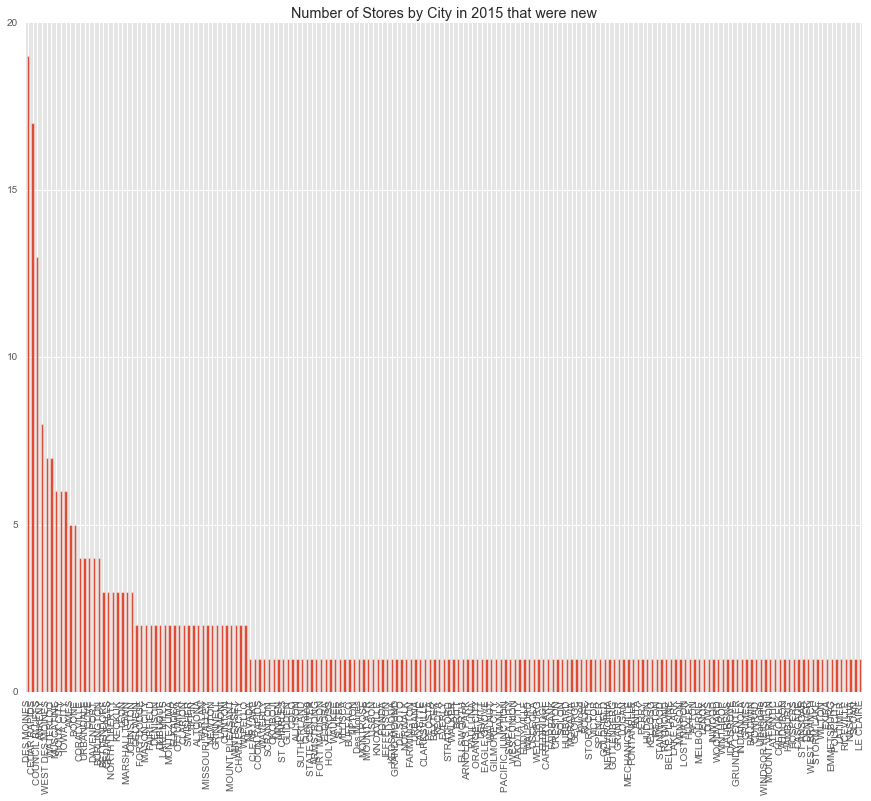

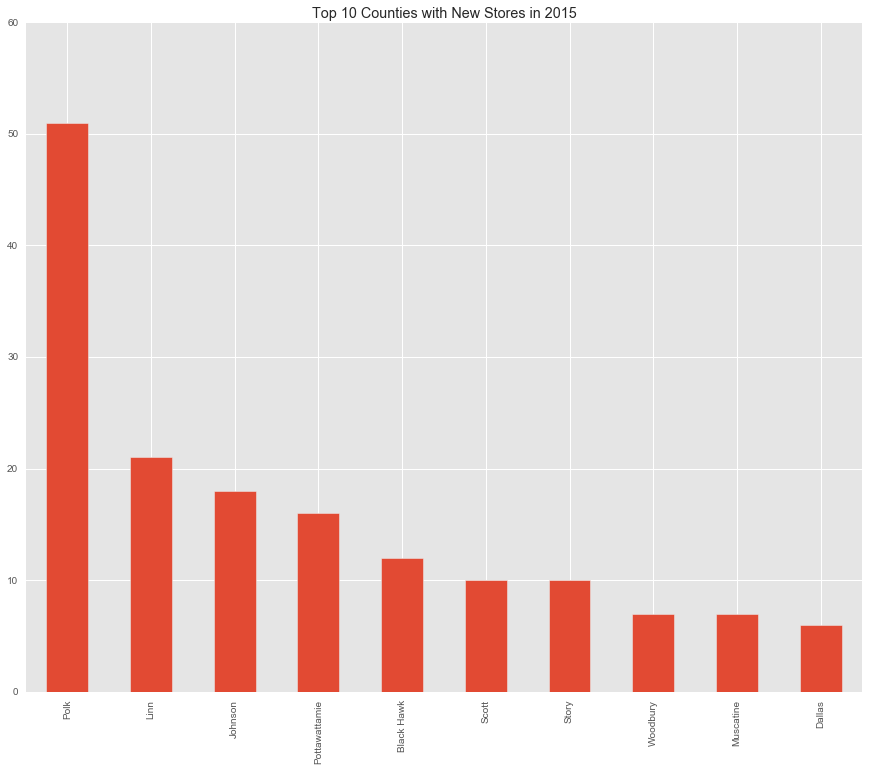

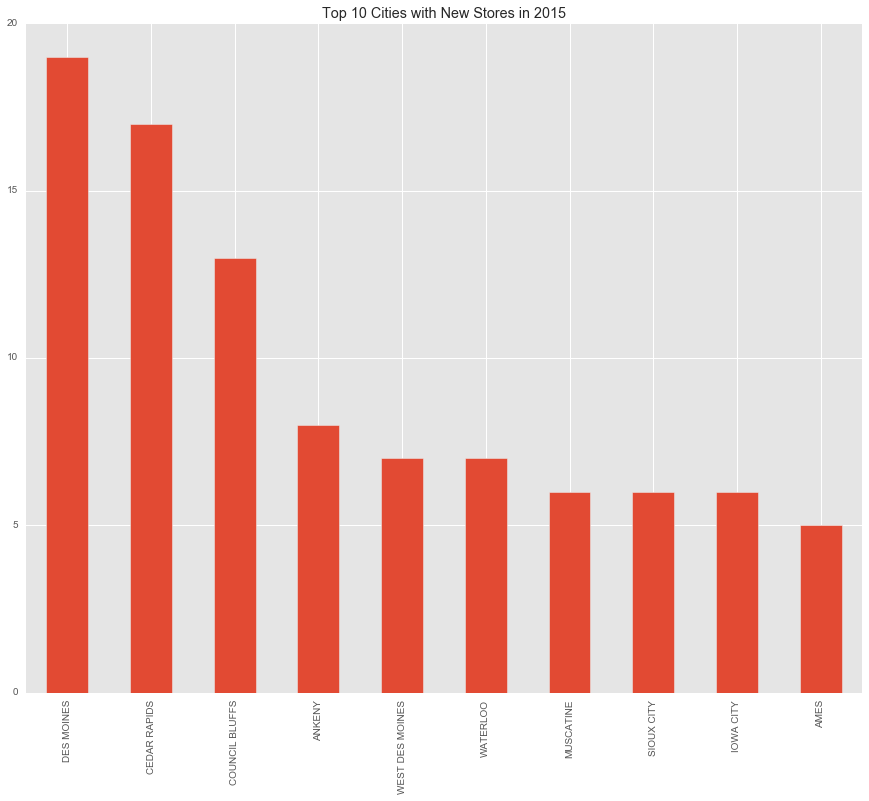

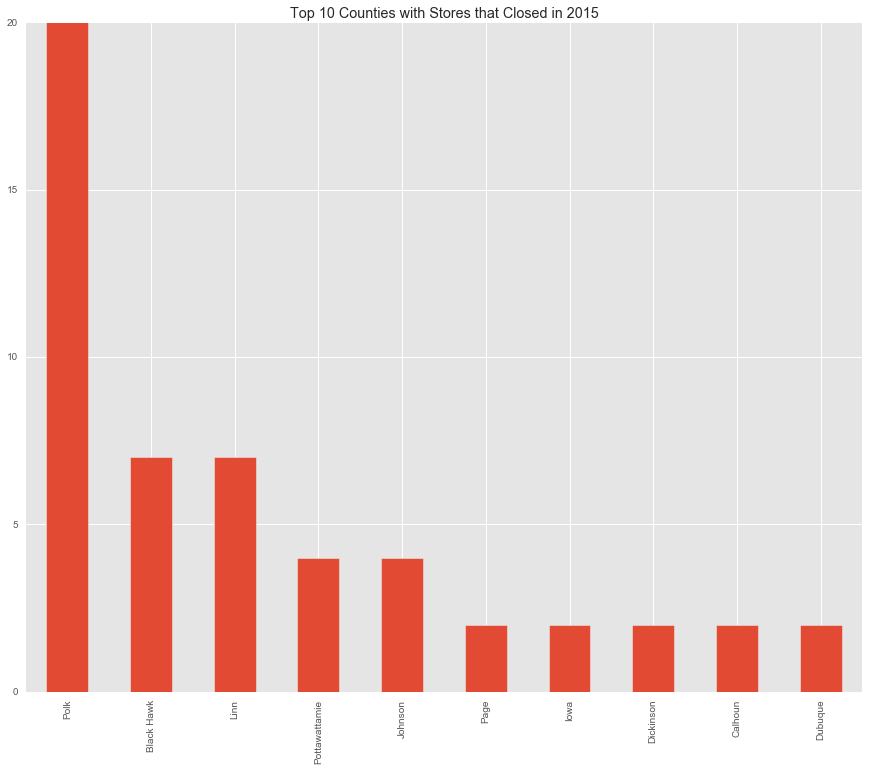

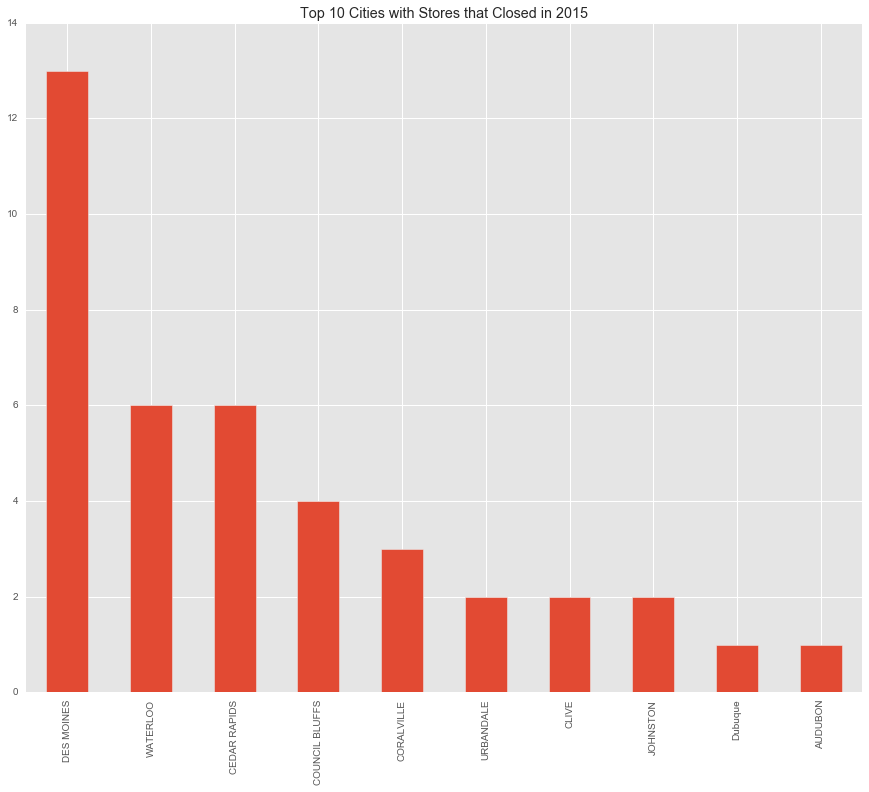

In [11]:
#I want to chart the count of new 2015 stores by county, zip, and city.

plt.figure(1)
sales_2015_new['Zip Code'].value_counts().plot(kind = 'bar', figsize = (15,12))
plt.title("Number of Stores by Zip Code in 2015 that were new")

plt.figure(2)
sales_2015_new['County'].value_counts().plot(kind = 'bar', figsize = (15,12))
plt.title("Number of Stores by County in 2015 that were new")

plt.figure(3)
sales_2015_new['City'].value_counts().plot(kind = 'bar', figsize = (15,12))
plt.title("Number of Stores by City in 2015 that were new")

plt.figure(4)
sales_2015_new['County'].value_counts()[:10].plot(kind = 'bar', figsize = (15,12))
plt.title("Top 10 Counties with New Stores in 2015")

plt.figure(5)
sales_2015_new['City'].value_counts()[:10].plot(kind = 'bar', figsize = (15,12))
plt.title("Top 10 Cities with New Stores in 2015")

plt.figure(6)
sales_2015_closed['County'].value_counts()[:10].plot(kind = 'bar', figsize = (15,12))
plt.title("Top 10 Counties with Stores that Closed in 2015")

plt.figure(7)
sales_2015_closed['City'].value_counts()[:10].plot(kind = 'bar', figsize = (15,12))
plt.title("Top 10 Cities with Stores that Closed in 2015")

#I want to chart its proportion to stores that were open for the whole timeperiod.

In [15]:
#Concat the three dfs. I want to get the total stores by county for 2015.

stores_2015 = pd.concat([sales, sales_2015_closed, sales_2015_new], ignore_index = True)

In [17]:
print sales.shape
print sales_2015_closed.shape
print sales_2015_new.shape

(795, 33)
(90, 13)
(318, 13)


In [54]:
#Value Counts for stores by datasets
test = sales['County'].value_counts()
test2 = sales_2015_new['County'].value_counts()
stores_city_2015full = sales['City'].value_counts()
stores_city_2015new = sales_2015_new['City'].value_counts()
test3 = sales_2015_closed['Zip Code'].value_counts()
test4 = sales_2015_closed['County'].value_counts()
test5 = sales_2015_closed['City'].value_counts()
print "Top 10 Zip Codes for Closed Stores 2015"
print test3[:10]
print ""
print "Top 10 Counties for Closed Stores, 2015"
print test4[:10]
print ""
print "Top 10 Cities for Closed Stores, 2015"
print test5[:10]
print ""
print ""
print "Top 10 Counties for New Stores, 2015"
print test2[:10]
print ""
print "Top 10 Cities for New Stores, 2015"
print stores_city_2015new[:10]

print "Top 10 Counties for Stores, 2015"
print test[:10]
print ""
print "Top 10 Cities for Stores, 2015"
print stores_city_2015full[:10]




Top 10 Zip Codes for Closed Stores 2015
50322    4
51501    4
52402    3
52241    3
50701    3
52404    3
50315    2
50310    2
50703    2
50300    2
Name: Zip Code, dtype: int64

Top 10 Counties for Closed Stores, 2015
Polk             20
Black Hawk        7
Linn              7
Pottawattamie     4
Johnson           4
Page              2
Iowa              2
Dickinson         2
Calhoun           2
Dubuque           2
Name: County, dtype: int64

Top 10 Cities for Closed Stores, 2015
DES MOINES        13
WATERLOO           6
CEDAR RAPIDS       6
COUNCIL BLUFFS     4
CORALVILLE         3
URBANDALE          2
CLIVE              2
JOHNSTON           2
Dubuque            1
AUDUBON            1
Name: City, dtype: int64


Top 10 Counties for New Stores, 2015
Polk             51
Linn             21
Johnson          18
Pottawattamie    16
Black Hawk       12
Scott            10
Story            10
Woodbury          7
Muscatine         7
Dallas            6
Name: County, dtype: int64

Top 10 Citie

In [151]:
#Can I take all the stores that closed in 2015, and for their counties, find the rest of the stores?

#Groupby of the three dataframes by County and then getting the number of stores in each county.
sales_2015_closed_county = sales_2015_closed['County'].value_counts()
sales_2015_new_county = sales_2015_new.groupby(['County'])['Store Number'].agg(len)
#sales_existing_2015_county = sales.groupby(['County'])['Store Number'].agg(len)

sales_2015_closed_county[0]



#Can I get the total number of stores by county?


#creating a dictionary for the total count of stores by the 2015 closed store dataframe

#test[test.index[0]]+test4[test4.index[0]]+test2[test4.index[0]]


20

In [142]:
sales_2015_closed_county
#sales_2015_closed_county[sales_2015_closed_county.index[3]]

KeyError: 'Store Number'

In [93]:
#I want to check on the sales by county for stores in 2015 vs closed stores in 2015.
#This would be charting county to sales2015county
#Not sure if pivot is best way to do this.
sales_county_2015 = pd.pivot_table(sales, index = ['County'], values = ['sales2015county'])


AttributeError: 'DataFrame' object has no attribute 'value'

In [71]:
sales['sales2015county']

0      14795417.30
1       2995026.97
2      14795417.30
3        797396.11
4      56674297.40
5       3508198.61
6        511117.20
7        400470.69
8       3725494.03
9      56674297.40
10     13020933.64
11      1733819.91
12       100596.80
13      7827313.86
14      8706224.87
15      1879416.31
16       291363.21
17      7827313.86
18      1491146.72
19     56674297.40
20       952549.95
21      7585724.01
22      7585724.01
23     56674297.40
24      1630094.93
25      3635473.79
26      3635473.79
27     20374018.21
28     20374018.21
29     13020933.64
          ...     
765     1557412.77
766      511117.20
767      984246.37
768     1630094.93
769      797396.11
770    18119679.48
771    56674297.40
772     7692077.76
773     1733819.91
774    18119679.48
775     5541197.41
776      249044.55
777     2823123.61
778     7827313.86
779    14795417.30
780     7692077.76
781     1879416.31
782    56674297.40
783      344823.60
784      842844.60
785    56674297.40
786    14795

In [ ]:
#The only continuous relationship I can think of would be retailpriceperliter compared to sales, since that could influence the amount of sales.
#other variables are categorical, even zip code. Though number of days open is also decent...

In [ ]:
# Fit a linear model

# Plot the data and the best fit line

# Compute the model fit


In [ ]:
# Predict Total 2016 sales, compare to 2015


In [ ]:
# Try per zip code or city to get better resolution



In [ ]:
# Filter out stores that opened or closed throughout the year
# If this wasn't done already


In [ ]:
# Fit another model

# Compute the model fit


In [ ]:
# Predict Total 2016 sales, compare to 2015
